# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
version = 'v1/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/'+version


os.system("mkdir -p "+ plotDir)

0

# Loading

In [3]:
data_home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/'
sig_home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/'
# SignalInput = 'CTAUSignalSummaryTableBin2Rebin.txt'
OLDSignalInput = 'SignalSummaryTableBin2Rebin.txt' 
DataInput = 'PredictionSummaryTableBin2Rebin.txt'

In [4]:

years = []
years = [
            '2016',
            '2017',
            '2018',
]

data_bin2 = {}
data_bin2err = {}

data_f=open(data_home_dir+DataInput, 'r')
for data_l in data_f:
    
    if 'Data' in data_l:
        data_ws = data_l.split('|')
        
 
        
        year = data_ws[1].split(' ')[2]
        bin2 = float(data_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(data_ws[4].lstrip(' ').rstrip(' '))
        
 
        
        data_bin2[year] = bin2
        data_bin2err[year] = bin2err
        
data_f.close()



In [5]:
data_f=open(data_home_dir+DataInput, 'r')
print(data_f.read())
data_f.close()

data_bin2_sum = 0
data_bin2_sum_err_tmp = 0
for year in years:
    print(year, data_bin2[year], data_bin2err[year])
    data_bin2_sum += data_bin2[year]
    data_bin2_sum_err_tmp += pow(data_bin2err[year],2)

data_bin2_sum_err = round(math.sqrt(data_bin2_sum_err_tmp),2)

print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)


+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
|   Sample  | method | Bin 2 Prediction | Bin 2 Prediction Error | Bin 2 Prediction Error Up | Bin 2 Prediction Error Low |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
| Data 2018 | 1D pt  |       0.58       |          0.26          |            0.35           |            0.18            |
| Data 2017 | 1D pt  |       0.88       |          0.45          |            0.61           |            0.29            |
| Data 2016 | 1D pt  |       1.47       |          0.58          |            0.74           |            0.41            |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
2016 1.47 0.58
2017 0.88 0.45
2018 0.58 0.26
Data sum 2.93
Data sum err 0.78


In [6]:
sig0_f=open(sig_home_dir+OLDSignalInput, 'r')

sig_bin2 = {}
sig_bin2err = {}
sig_bin2_arr = []
sig_bin2err_arr = []

for sig_l in sig0_f:
    
    sig_ws = sig_l.split('|')

    if "." in sig_l:
#         print('sample year',sig_ws[1].lstrip(' ').rstrip(' '))
#         print('sample year', len(sig_ws[1].lstrip(' ').rstrip(' ')))
#         print('bin 2 prediction ' , sig_ws[3].lstrip(' ').rstrip(' '))
#         print('bin 2 prediction ' , len(sig_ws[3].lstrip(' ').rstrip(' ')))
#         print('bin 2 error ', sig_ws[4].lstrip(' ').rstrip(' '))
#         print('bin 2 error ', len(sig_ws[4].lstrip(' ').rstrip(' ')))

 
    
        mass = sig_ws[1].lstrip(' ').rstrip(' ')
        bin2 = float(sig_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(sig_ws[4].lstrip(' ').rstrip(' '))

        sig_bin2[mass] = bin2
        sig_bin2err[mass] = bin2err
        
        sig_bin2_arr.append(bin2)
        sig_bin2err_arr.append(bin2err)


sig0_f.close()

In [7]:
 

sig0_f=open(sig_home_dir+OLDSignalInput, 'r')
print(sig0_f.read())
sig0_f.close()

masses = np.array([127, 150, 175, 200, 250, 300, 400])

print('------------SUM----------')   
print('mass[GeV],  sig_sum, err')   
for mass in masses:
    print(mass, sig_bin2[str(mass)] , sig_bin2err[str(mass)] )


+--------+-----------------+-------------+-------------+
| Sample |      Weight     | Bin 2 Yield | Bin 2 Error |
+--------+-----------------+-------------+-------------+
|  127   | [5.6951445e-05] |    437.61   |    20.92    |
|  150   | [2.1877613e-05] |    204.99   |    14.32    |
|  175   | [1.5398517e-05] |    189.27   |    13.76    |
|  200   |  [8.116029e-06] |    153.08   |    12.37    |
|  250   | [5.1101733e-06] |    186.64   |    13.66    |
|  300   | [1.8683509e-06] |    153.39   |    12.38    |
|  400   |  [6.086827e-07] |    115.9    |    10.77    |
+--------+-----------------+-------------+-------------+
------------SUM----------
mass[GeV],  sig_sum, err
127 437.61 20.92
150 204.99 14.32
175 189.27 13.76
200 153.08 12.37
250 186.64 13.66
300 153.39 12.38
400 115.9 10.77


# Making Datacards

In [8]:
def make_datacard(outDataCardsDir,cardName, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred):
    text_file = open(outDataCardsDir+cardName, "w")
    text_file.write('# Simple counting experiment, with one signal and a few background processes \n')
    text_file.write('# Simplified version of the SUSY LLP analysis for mH = 200 GeV \n')

    text_file.write('imax {0} \n'.format(1))
    text_file.write('jmax {0} \n'.format(1))
    text_file.write('kmax * \n')
    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t bin1 \n')
    text_file.write('observation \t {0:6.2f} \n'.format(0))
    text_file.write('------------------------------ \n')  
    text_file.write('bin \t bin1 \t bin1 \n')
    text_file.write('process sig \t bkg \n')
    text_file.write('process 0 \t 1 \n')
    text_file.write('rate \t {0} \t {1} \n'.format(sig_yield, bkg_yield))
    text_file.write('------------------------------ \n')  
 
#     #### uncertainties ####
    text_file.write('------------------------------ \n')  
    text_file.write('lumi\t lnN \t 1.025000 \t - \n')
    text_file.write('signal_yield \t lnN  \t {0:6.6f} \t - \n'.format(1+sig_unc))    
    text_file.write('signal_stat \t lnN  \t {0} \t - \n'.format(1+sig_stat))    
    text_file.write('bkg_yield \t lnN  \t - \t {0:6.6f} \n'.format(1+bkg_unc))    
    text_file.write('bkg_pred \t lnN  \t - \t {0} \n'.format(1+bkg_pred))    

    
    text_file.close()

# Simple counting experiment, with one signal and a few background processes 
# Simplified version of the SUSY LLP analysis for mH = 200 GeV
imax 1  number of channels
jmax 1  number of backgrounds
kmax *  number of nuisance parameters (sources of systematical uncertainties)
------------
# we have just one channel, in which we observe 0 events
bin bin1
observation 0
------------
# now we list the expected events for signal and all backgrounds in that bin
# the second 'process' line must have a positive number for backgrounds, and 0 for signal
# then we list the independent sources of uncertainties, and give their effect (syst. error)
# on each process and bin
bin             bin1 bin1  
process         sig  bkg
process          0     1
rate           240  2.93
------------
lumi    lnN    1.025    -  #   lumi affects signal. lnN = lognormal
sig_yield lnN  1.2     -   #   20% uncertainty on signal yields
bkg_yield lnN  -      1.5  #   50% uncertainty on bkg yields


In [9]:
print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)


Data sum 2.93
Data sum err 0.78


In [10]:
 

print('------------SUM----------')   
print('mass[GeV],  sig_sum, err')   
for mass in masses:
    print(mass, sig_bin2[str(mass)] , sig_bin2err[str(mass)] )


------------SUM----------
mass[GeV],  sig_sum, err
127 437.61 20.92
150 204.99 14.32
175 189.27 13.76
200 153.08 12.37
250 186.64 13.66
300 153.39 12.38
400 115.9 10.77


In [11]:
npts = len(masses) 
masses_err = np.zeros(npts)
test = np.ones(npts)
print(masses_err)
lumi=137000
print(sig_bin2)
print(np.array(sig_bin2))
print(sig_bin2_arr)
sig_bin2_arr = np.array(sig_bin2_arr)
sig_bin2err_arr = np.array(sig_bin2err_arr)
print(sig_bin2_arr)
print(sig_bin2err_arr)
print(masses)


[0. 0. 0. 0. 0. 0. 0.]
{'127': 437.61, '150': 204.99, '175': 189.27, '200': 153.08, '250': 186.64, '300': 153.39, '400': 115.9}
{'127': 437.61, '150': 204.99, '175': 189.27, '200': 153.08, '250': 186.64, '300': 153.39, '400': 115.9}
[437.61, 204.99, 189.27, 153.08, 186.64, 153.39, 115.9]
[437.61 204.99 189.27 153.08 186.64 153.39 115.9 ]
[20.92 14.32 13.76 12.37 13.66 12.38 10.77]
[127 150 175 200 250 300 400]


137 fb^{-1} (13 TeV)


Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/SignalYields/v1/SignalYield.png has been created


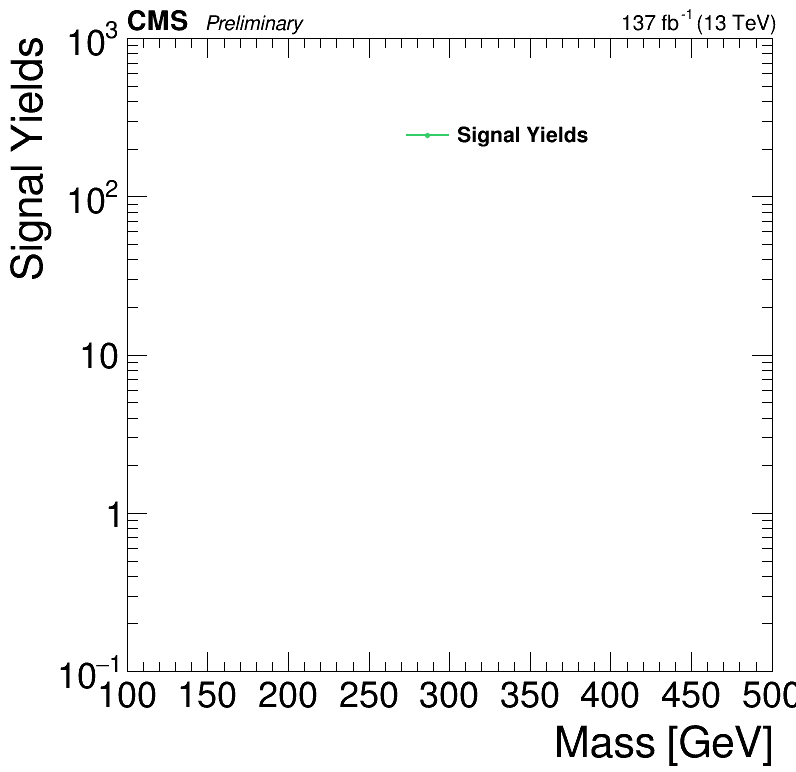

In [12]:
# plot 
rt.gStyle.SetOptFit(1011)    

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.5,0.73,0.80,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h_sig = rt.TGraphErrors(npts, masses, masses, masses_err, masses_err)
# h_sig = rt.TGraphErrors(npts, masses, test , masses_err, sig_bin2err_arr)
# h_sig = rt.TGraphErrors(npts, masses, sig_bin2_arr , masses_err, sig_bin2err_arr)


h_sig.SetTitle(" ; Mass [GeV];Signal Yields");
leg.AddEntry(h_sig, "Signal Yields", "PL")
# leg.SetHeader( "Error x 5")
h_sig.SetLineColor(845)
h_sig.SetLineWidth(2)
h_sig.SetMarkerColor(845)
h_sig.SetMarkerStyle(20)
h_sig.SetMarkerSize(0.5)
h_sig.GetXaxis().SetLimits(100,500.0)
h_sig.GetYaxis().SetRangeUser(0.1,1e+3)
h_sig.GetXaxis().SetTitleOffset(1)

h_sig.Draw('ALPsame')

tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText = True
CMS_lumi.extraText   = "Preliminary"

iPos = 0
if( iPos==0 ): CMS_lumi.relPosX = 0.12
CMS_lumi.CMS_lumi(c, 4, 0)
leg.Draw()
c.SetRightMargin(0.03)
c.SetLogy()
# c.SetLogx()

c.Draw()
#save
outDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/SignalYields/'+version

os.system("mkdir -p "+ outDir)
c.SaveAs(outDir+'SignalYield.png')

In [19]:
for mass in masses:
    card_name = 'ggH_LLP_m'+str(mass)+'_ctau1m.txt'
    if sig_bin2[str(mass)]  !=0:
        sig_unc = sig_bin2err[str(mass)] / sig_bin2[str(mass)]
    else:
        sig_unc = 0.2
    sig_stat = 0.2
    bkg_unc = data_bin2_sum_err / data_bin2_sum
    bkg_pred = 0.5
    sig_yield = sig_bin2[str(mass)] 
    bkg_yield = data_bin2_sum
    make_datacard(plotDir, card_name, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred)
    print(plotDir+card_name)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m127_ctau1m.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m150_ctau1m.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m175_ctau1m.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m200_ctau1m.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m250_ctau1m.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m300_ctau1m.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m400_ctau1m.txt


In [20]:
for mass in masses:
        card_name = 'ggH_LLP_m'+str(mass)+'_ctau1m.txt'
    #     print(plotDir+card_name)
        print('combine -M AsymptoticLimits '+plotDir+card_name+' -n _ggH_LLP_m'+str(mass)+'_ctau1m  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m'+str(mass)+'_ctau1m.txt' )


combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m127_ctau1m.txt -n _ggH_LLP_m127_ctau1m  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m127_ctau1m.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m150_ctau1m.txt -n _ggH_LLP_m150_ctau1m  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m150_ctau1m.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m175_ctau1m.txt -n _ggH_LLP_m175_ctau1m  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m175_ctau1m.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_m200_ctau1m.txt -n _ggH_LLP_m200_ctau1m  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_ggH_LLP_m200_ctau1m.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/DataCards/v1/ggH_LLP_

# Limit plot

In [13]:
rtDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/GMSB_LLP_V1p17_v2/'
rtFiles = {}
rtTrees = {}
Limits = {}
LimitErrs = {}

for mass in masses:
  
    rtName = 'higgsCombine_ggH_LLP_m'+str(mass)+'_ctau1m.AsymptoticLimits.mH125.root'
#     higgsCombine_ggH_LLP_m400_ctau1m.AsymptoticLimits.mH125.root
    print('mass ', mass, ' GeV')
#     print(rtName)
    rtFiles[str(mass)] = rtDir+rtName

    root_dir = uproot.open(rtFiles[str(mass)])
    rtTrees[str(mass)] = root_dir['limit']

    print( "-2\u03C3 , -\u03C3 , exp, +\u03C3 , +2\u03C3 , obs")
    v = rtTrees[str(mass)]
    limit = v['limit'].array()
    print(limit)
    limitErr = v['limitErr'].array()
    print(limitErr)

    Limits[str(mass)] = limit
    LimitErrs[str(mass)] = limitErr


mass  127  GeV
-2σ , -σ , exp, +σ , +2σ , obs
[0.00567627 0.00849075 0.01210937 0.01944618 0.03112113 0.01232974]
[0.         0.         0.         0.         0.         0.00047329]
mass  150  GeV
-2σ , -σ , exp, +σ , +2σ , obs
[0.01263428 0.01755638 0.02695313 0.04242396 0.06682543 0.02679155]
[0.         0.         0.         0.         0.         0.00036341]
mass  175  GeV
-2σ , -σ , exp, +σ , +2σ , obs
[0.01400147 0.01912498 0.02890625 0.04595904 0.0724996  0.02901077]
[0.         0.         0.         0.         0.         0.00034841]
mass  200  GeV
-2σ , -σ , exp, +σ , +2σ , obs
[0.01694031 0.02362704 0.03554688 0.05708396 0.09016004 0.03570561]
[0.         0.         0.         0.         0.         0.00042219]
mass  250  GeV
-2σ , -σ , exp, +σ , +2σ , obs
[0.01419067 0.01938343 0.02929688 0.04658011 0.07347932 0.02941737]
[0.         0.         0.         0.         0.         0.00034285]
mass  300  GeV
-2σ , -σ , exp, +σ , +2σ , obs
[0.01694031 0.02362704 0.03554688 0.05680058

In [14]:
print(masses)

xsecs = np.array([10.31, 1e-03*3832.31, 1e-03*2583.96, 1e-03*1335.62, 1e-03*810.24, 1e-03*284.855, 1e-03*88.7372])
print(xsecs)
br=0.5824*0.5824
print(br)
xsecs*=br
print(xsecs)


[127 150 175 200 250 300 400]
[10.31       3.83231    2.58396    1.33562    0.81024    0.284855
  0.0887372]
0.33918976
[3.49704643 1.29988031 0.87645277 0.45302863 0.27482511 0.0966199
 0.03009875]


In [17]:
XSECs = {}
i=0
for mass in masses:
    XSECs[str(mass)] = xsecs[i]
    i+=1
    
print(XSECs)

{'127': 3.4970464256000002, '150': 1.2998803091456002, '175': 0.8764527722496, '200': 0.4530286272512, '250': 0.27482511114240005, '300': 0.09661989908480001, '400': 0.030098749571072}


In [18]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


expL = []
exp1sigP = []
exp1sigM = []
exp2sigP = []
exp2sigM = []
for mass in masses:
    expL.append(Limits[str(mass)][2]*XSECs[str(mass)])
    exp1sigP.append(Limits[str(mass)][1]*XSECs[str(mass)])
    exp1sigM.append(Limits[str(mass)][3]*XSECs[str(mass)])
    exp2sigP.append(Limits[str(mass)][0]*XSECs[str(mass)])
    exp2sigM.append(Limits[str(mass)][4]*XSECs[str(mass)])
    
expL = np.array(expL)
expL1sigP= np.array(exp1sigP)
expL1sigM= np.array(exp1sigM)
expL2sigP= np.array(exp2sigP)
expL2sigM= np.array(exp2sigM)

print(expL)
print(exp1sigP)
print(exp1sigM)
print(exp2sigP)
print(exp2sigM)

exp1sig = np.array(np.hstack((exp1sigP, np.flip(exp1sigM)))) 
exp2sig = np.array(np.hstack((exp2sigP, np.flip(exp2sigM)))) 

print(exp1sig)
print(exp2sig)

masses_2e = np.array(np.hstack((masses, np.flip(masses)))) 
print(masses_2e)
 

[0.04234705 0.03503584 0.02533496 0.01610375 0.00805152 0.00343454
 0.00142264]
[0.02969255868856316, 0.022821193286506357, 0.016762145895665628, 0.010703727596104818, 0.0053270534362500005, 0.0022828426681155106, 0.0009455876665665117]
[0.06800421125160294, 0.05514606516547186, 0.0402809284759429, 0.025860670006558107, 0.012801382813964065, 0.005488066453921349, 0.002273239701861402]
[0.019850178075000002, 0.016423048339425, 0.012271623167616152, 0.007674444811326445, 0.003899953512000001, 0.0016367709204192769, 0.0006779751025591239]
[0.10883202049728165, 0.08686505685698556, 0.06354247806532604, 0.040845080081689675, 0.020193963544157815, 0.00870162872423852, 0.003604345235813299]
[0.02969256 0.02282119 0.01676215 0.01070373 0.00532705 0.00228284
 0.00094559 0.00227324 0.00548807 0.01280138 0.02586067 0.04028093
 0.05514607 0.06800421]
[0.01985018 0.01642305 0.01227162 0.00767444 0.00389995 0.00163677
 0.00067798 0.00360435 0.00870163 0.02019396 0.04084508 0.06354248
 0.08686506 0.1

137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/LimitPlots/v1/Limit_1m.png has been created


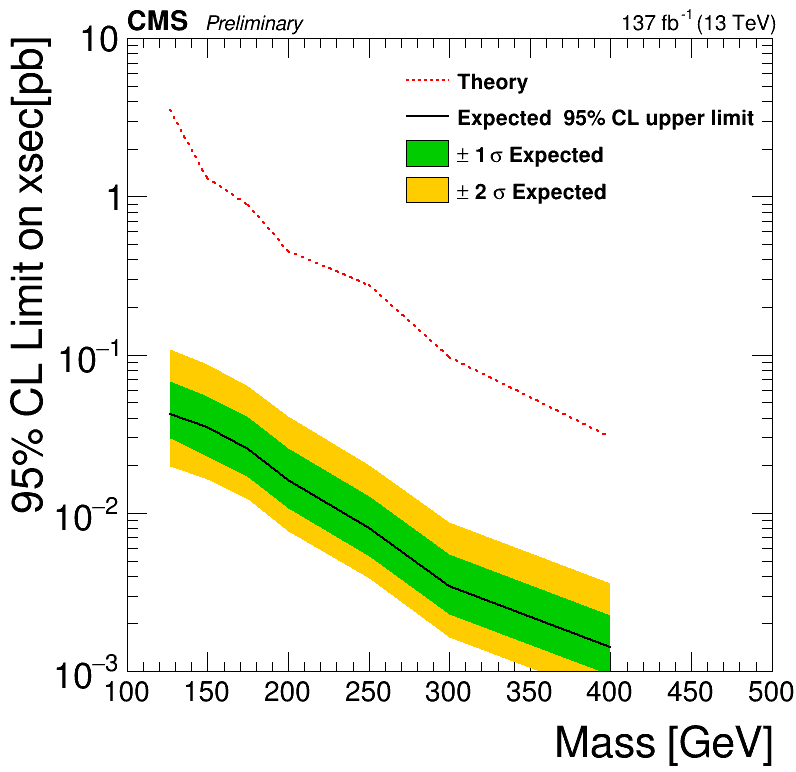

In [19]:
rt.gStyle.SetOptFit(1011)

# h_exp = {}
# h_exp1sig = {}
# h_exp2sig = {}


c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.5,0.73,0.80,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h_the = create_TGraph(masses, xsecs,  axis_title=['Mass [GeV]', '95% CL Limit on xsec[pb]'])
h_exp = create_TGraph(masses, expL,  axis_title=['Mass [GeV]', '95% CL Limit on xsec[pb]'])

h_exp1sig = create_TGraph(masses_2e,  exp1sig)
h_exp2sig = create_TGraph(masses_2e,  exp2sig)


leg.AddEntry(h_the, "Theory", "L")
leg.AddEntry(h_exp, "Expected  95% CL upper limit", "L")
leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')
h_the.SetLineStyle(2)
h_the.SetLineColor(2)
h_the.SetLineWidth(2)
h_exp.SetLineColor(1)
h_exp.SetLineWidth(2)
h_exp1sig.SetFillColor(417)
h_exp2sig.SetFillColor(800)
h_exp.GetXaxis().SetLimits(100,500.0)
h_exp.GetXaxis().SetLabelSize(0.04)
h_exp.GetYaxis().SetRangeUser(1e-3,1e+1)
h_exp.GetXaxis().SetTitleOffset(1)

h_exp.Draw('LA')
h_exp2sig.Draw( 'Fsame')
h_exp1sig.Draw('Fsame')
h_exp.Draw('Lsame')
h_the.Draw('Lsame')

tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText = True
CMS_lumi.extraText   = "Preliminary"

iPos = 0
if( iPos==0 ): CMS_lumi.relPosX = 0.12
CMS_lumi.CMS_lumi(c, 4, 0)
leg.Draw()
c.SetRightMargin(0.03)
c.SetLogy()
# c.SetLogx()

c.Draw() 
LimDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/LimitPlots/'+version

os.system("mkdir -p "+ LimDir)
c.SaveAs(LimDir+'Limit_1m.png')